# Titanic Survival Part 3: Training Classifiers for Accuracy

In Part 1 of this project I conduct Exploratory Data Analysis (EDA) of the Titanic training data using R. This exploration can be found [here.](http://rpubs.com/BigBangData/512981)

In Part 2 I continue the exploration using Python and building a couple of basic models. This is not intended as the goal of the competition, just an exploration of modeling in Python.

In Part 3 (this notebook) I create a pre-processing pipeline and train several models in Python using the scikit-learn module, and submit my predictions to the competition.


In [1]:
from datetime import datetime
import time

dt_object = datetime.fromtimestamp(time.time())
dt_object = str(dt_object).split('.')[0]

Date, Time = dt_object.split(' ')
print('Revised on: ' + Date)

Revised on: 2020-01-16


## Pre-Processing

In [2]:
# import modules
import pandas as pd
import numpy as np

# custom pre-processing module
import processing_pipeline as pp  

# load datasets
train_data = pd.read_csv("../input/train.csv")
test_data = pd.read_csv("../input/test.csv")

# separate target from predictors in training set
survived_labels = train_data['Survived'].copy()
train_data_nolabel = train_data.drop('Survived', axis=1)

# get processed training data and labels
X = pp.process_train(train_data_nolabel)
y = survived_labels.to_numpy()

In [3]:
# 18 full data features
for i, e in enumerate(train_data_nolabel.columns):
    print(i, e)

0 IsMale
1 Embarked_S
2 Embarked_Q
3 Title_Mr
4 Title_Mrs
5 Title_Miss
6 Pclass_1
7 Pclass_2
8 Deck_A
9 Deck_B
10 Deck_C
11 Deck_D
12 Deck_E
13 Deck_F
14 Age_minmax
15 NameLength_minmax
16 NumRelatives_minmax
17 FarePerPerson_minmax


## Modeling

### Stochastic Gradient Descent

In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
     
sgd_clf = SGDClassifier(random_state=42)
    
accuracies = cross_val_score(estimator=sgd_clf, X=X, y=y, cv=100)

In [5]:
mn, sd = round(accuracies.mean(),4), round(accuracies.std(),4)
mn, sd

(0.7824, 0.1362)

As seen in the previous notebook, the SDG model is too variable.

### Random Forests

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import pickle

A grid search shows which are the best parameters for the highest accuracy across a range of values. Here we construct a 20 x 2 x 2 = 80-parameter grid search that explores various numbers of estimators and four main categories of models (bootsrapped or not, gini or entropy as IG criterion):


In [7]:
# load pickled model so as to skip the grid search in future notebook runs
try:
    grid_search = pickle.load(open('./RandomForest_GridSearch.sav', 'rb'))
except FileNotFoundError as e:
    num_estimators = list(range(50,5000,250))
    
    grid_param = {
        'n_estimators': num_estimators,
        'criterion': ['gini', 'entropy'],
        'bootstrap': [True, False]
    }
    
    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_grid=grid_param,
                               scoring='accuracy',
                               cv=5,
                               n_jobs=-1)
    
    # running the grid search: this takes time...
    grid_search.fit(X,y)
    
    # pickle the model for future ease
    pickle.dump(grid_search, open('./RandomForest_GridSearch.sav', 'wb'))

In [8]:
# best arameters and the best accuracy
grid_search.best_params_ , round(grid_search.best_score_, 4)

({'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 300}, 0.8193)

In [9]:
import modeling_functions as mf

boot_gini, boot_entr, noot_gini, noot_entr = mf.transform_gridsearch_results(grid_search)

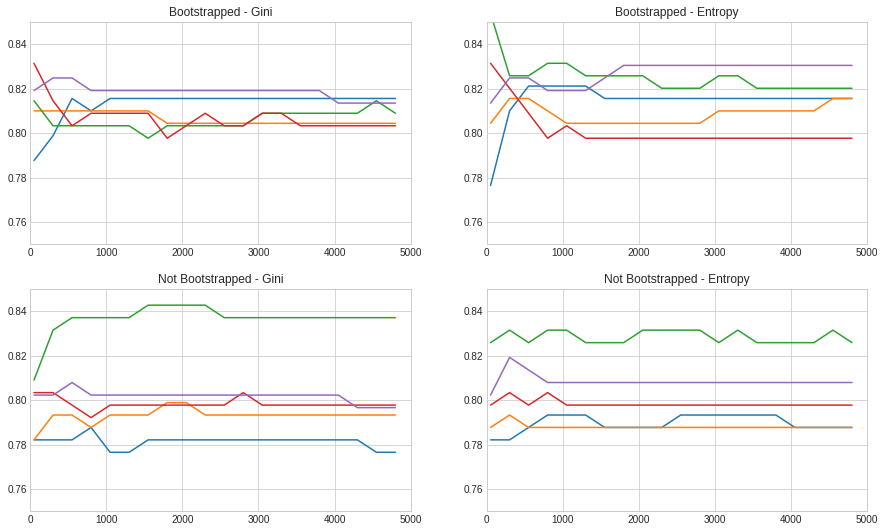

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')


# plotting the details for each category
plt.rcParams['figure.figsize'] = [15, 9]

mf.plot_single(boot_gini, 1, 'Bootstrapped - Gini')
mf.plot_single(boot_entr, 2, 'Bootstrapped - Entropy')
mf.plot_single(noot_gini, 3, 'Not Bootstrapped - Gini')
mf.plot_single(noot_entr, 4, 'Not Bootstrapped - Entropy')

We can see the "story" of each CV fold for each category: 
1. Bootstrapped and Gini - low variance but also low accuracy
2. Bootstrapped and Entropy - mid variance and high accuracy
3. Not Boostrapped and Gini - too much variance
4. Not Boostrapped and Entropy - high variance and perhaps low accuracy

Examining the mean accuracy of all CV folds per category in one comparison plot will be helpful.

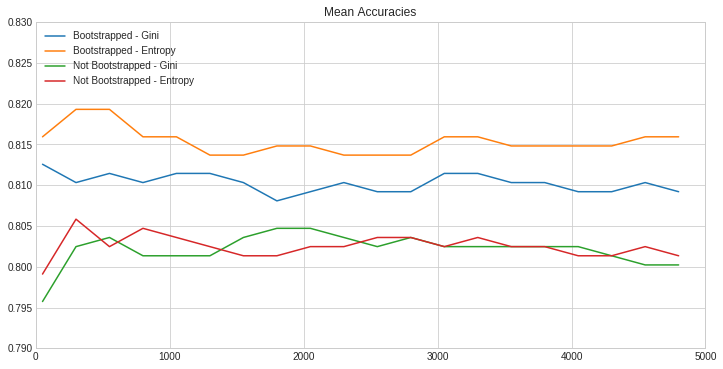

In [11]:
plt.rcParams['figure.figsize'] = [12, 6]
mf.plot_means(boot_gini, noot_gini, boot_entr, noot_entr, grid_search)

We can confirm that using entropy as the information gain criterion has the highest accuracies when bootstrapping - not bootstrapping is just a bad idea. 

It also looks as if we will not revisit that plateau of high accuracies around 200-500 number of estimators so we can focus our search efforts under 1000 estimators.

## Feature Selection with Random Forests

While we could stop here and train a classifier using the best parameters we found, it is often useful to verify that the full data is indeed offering the best accuracies, versus models on some optimal subset of the data.

In [12]:
from sklearn.feature_selection import SelectFromModel

# train full model on best classifier
forest_clf = RandomForestClassifier(bootstrap=True,
                                    criterion='entropy',
                                    n_estimators=300,
                                    random_state=42)
forest_clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [13]:
# create dataframe of labels and importance scores
importance_df = pd.DataFrame(list(zip(train_data_nolabel.columns, forest_clf.feature_importances_)),
                       columns=['Labels','Importance'])

importance_df.sort_values(by=['Importance'], ascending=False, inplace=True)

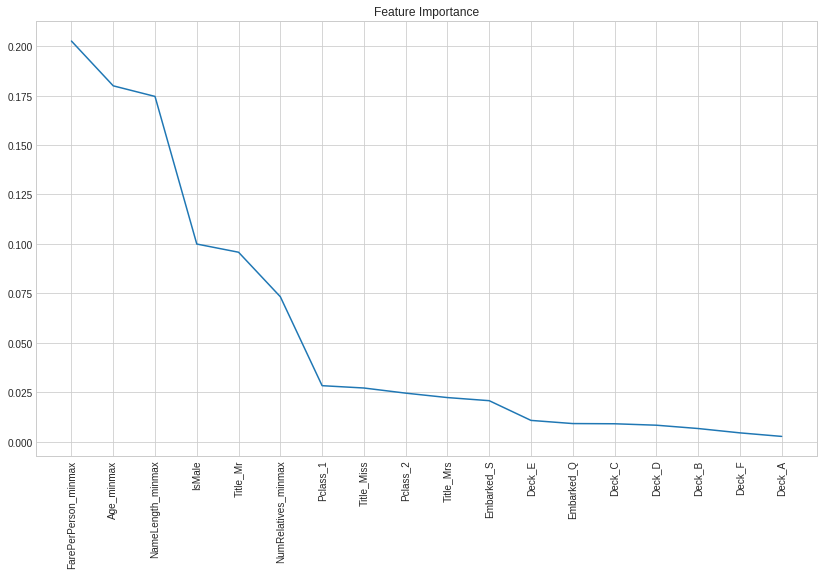

In [14]:
# plot an "elbow" plot of feature importance
plt.rcParams['figure.figsize'] = [14, 8]
mf.elbow_plot(importance_df['Labels'], 
           importance_df['Importance'])

We could select the subset of features based on elbow method since we have such a sharp turn at the seventh feature (Pclass_1):

In [15]:
rf_sub = importance_df[importance_df['Importance'] > 0.0275]
rf_sub

,Labels,Importance
17,FarePerPerson_minmax,0.202602
14,Age_minmax,0.179958
15,NameLength_minmax,0.174600
0,IsMale,0.099940
3,Title_Mr,0.095792
16,NumRelatives_minmax,0.073285
6,Pclass_1,0.028296


Notice that this is similar to using the `feature_selection` module from scikit-learn, which require a threshold to be used just as we did above:

In [16]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest_clf, threshold=0.0275)  

sfm.fit(X, y)

for ix in sfm.get_support(indices=True):
    print(importance_df['Labels'][ix] + ": " + str(round(importance_df['Importance'],4)[ix]))

IsMale: 0.0999
Title_Mr: 0.0958
Pclass_1: 0.0283
Age_minmax: 0.18
NameLength_minmax: 0.1746
NumRelatives_minmax: 0.0733
FarePerPerson_minmax: 0.2026


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# split data into 33% test and 66% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

In [18]:
# train full model
forest_clf = RandomForestClassifier(bootstrap=True,
                                    criterion='entropy',
                                    n_estimators=300,
                                    random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [19]:
# select best subset
sfm = SelectFromModel(forest_clf, threshold=0.025)

sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='entropy',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=300, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=42, verbose=0,
 

In [20]:
# create subsets with most important features
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [21]:
# train a new model on this subset
clf_important =  RandomForestClassifier(bootstrap=True,
                                        criterion='entropy',
                                        n_estimators=300,
                                        random_state=42)

clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [22]:
# predict on the test set using the full dataset
y_pred = forest_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.8114478114478114

In [23]:
# predict on the test set using the important subset model
y_important_pred = clf_important.predict(X_important_test)

accuracy_score(y_test, y_important_pred)

0.8148148148148148

## Recursive Feature Elimination with Cross Validation

In [24]:
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

# feature selection classifier
clf_feature_select = RandomForestClassifier(bootstrap=True,
                                            criterion='entropy',
                                            n_estimators=300,
                                            random_state=42)

# recursive feature elimination with cross validation
rfecv = RFECV(estimator=clf_feature_select, 
              step=1, 
              cv=5, 
              scoring = 'accuracy')

# grid search final classifier
final_clf = RandomForestClassifier(random_state=42)

CV_rfc = GridSearchCV(estimator=final_clf,
                      param_grid={
                           'n_estimators': list(range(200,550,15)),
                           'criterion': ['gini', 'entropy'],
                           'bootstrap': [True]
                       },                      
                      scoring='accuracy',
                      cv=5,
                      n_jobs=-1)

rf_pipeline  = Pipeline([('feature_select', rfecv),
                         ('classifier_CV', CV_rfc)])

In [25]:
try:
    rf_pipeline = pickle.load(open('./rfecv_rf_pipeline.sav', 'rb'))
except FileNotFoundError as e:
    rf_pipeline.fit(X_train, y_train)
    pickle.dump(rf_pipeline, open('./rfecv_rf_pipeline.sav', 'wb'))

In [26]:
rf_pipeline['classifier_CV'].cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_bootstrap', 'param_criterion', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [27]:
rf_pipeline['classifier_CV'].cv_results_['rank_test_score']

array([21,  3, 21, 21, 10, 43, 43, 21, 10, 21, 10, 21, 10, 10, 21, 10, 21,
       21, 21, 21, 21, 21, 21, 21, 43,  3,  3, 43, 10, 10, 21, 10, 21,  3,
       10,  3,  3,  1,  1, 21,  3, 21, 21, 10, 21, 21, 43, 43],
      dtype=int32)

In [28]:
rf_pipeline['classifier_CV'].best_params_

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 395}

In [29]:
rf_pipeline['classifier_CV'].best_score_

0.8238255033557047

In [30]:
n_estimators = list(rf_pipeline['classifier_CV'].cv_results_['param_n_estimators'][:24])
gini_mean_test_scores = rf_pipeline['classifier_CV'].cv_results_['mean_test_score'][:24]
entr_mean_test_scores = rf_pipeline['classifier_CV'].cv_results_['mean_test_score'][24:]

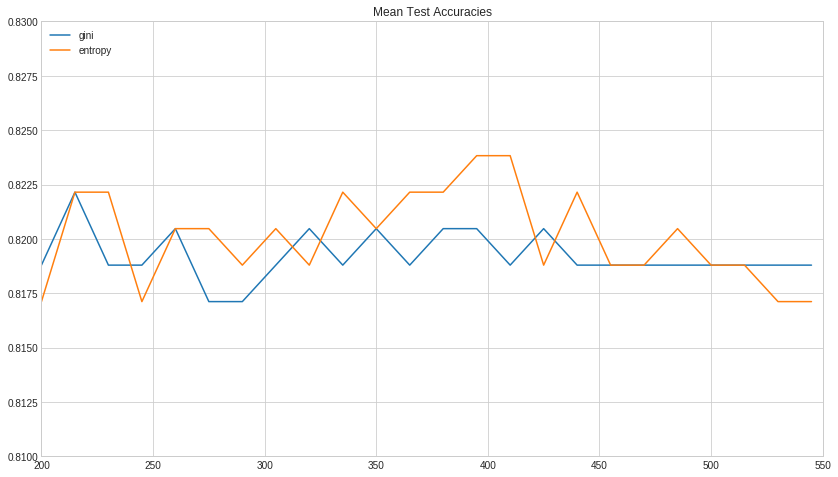

In [31]:
plt.plot(n_estimators, gini_mean_test_scores, label='gini')
plt.plot(n_estimators, entr_mean_test_scores, label='entropy')
plt.axis([200, 550, .81, .83]) 
plt.title('Mean Test Accuracies')
plt.legend(loc='upper left')
plt.show()

In [56]:
rf_predictions = rf_pipeline.predict(X_test)

In [102]:
def get_accuracy(preds, ytest):
    
    acc = []
    for i in range(0, len(preds)):
        if preds[i] == ytest[i]:
            acc.append(1)
        else:
            acc.append(0)
            
    return sum(acc)/len(acc)

In [103]:
rf_acc = get_accuracy(rf_predictions, y_test)
print("Accuracy: %.2f%%" % (rf_acc * 100.0))

Accuracy: 80.68%


In [104]:
rf_acc = accuracy_score(rf_predictions, y_test)
print("Accuracy: %.2f%%" % (rf_acc * 100.0))

Accuracy: 80.68%


In [105]:
# best model
rf_clf = RandomForestClassifier(bootstrap=True,
                                criterion='entropy',
                                n_estimators=395,
                                random_state=42)

In [106]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=395,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [107]:
best_preds = rf_clf.predict(X_test)

In [108]:
rf_best_acc = accuracy_score(best_preds, y_test)
print("Accuracy: %.2f%%" % (rf_best_acc * 100.0))

Accuracy: 81.36%


## XGBoost 

In [109]:
from xgboost import XGBClassifier

In [110]:
xgb_clf = XGBClassifier()

In [111]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [112]:
y_pred = xgb_clf.predict(X_test)

In [113]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.41%


In [98]:
xgb_acc = get_accuracy(y_pred, y_test)
print("Accuracy: %.2f%%" % (xgb_acc * 100.0))

Accuracy: 84.41%


## Cross Validation, Feature Selection, Tuning with XGBoost 